## 1. Install and import the libraries

In [ ]:
%pip install -U pip setuptools wheel
%pip install -U spacy
!python -m spacy download en_core_web_sm
%pip install gensim
%pip install pyLDAvis
%pip install seaborn

In [2]:
# libraries for text cleaning and manipulation
import ast
from bs4 import BeautifulSoup
import unicodedata
import re
import boto3
import pandas as pd
from collections import Counter
from itertools import chain
import json

In [3]:
# to show progress bar
from tqdm import tqdm
# for pretty printing
import pprint

In [4]:
# nlp library
import spacy

In [27]:
# for topic modelling
from gensim import corpora
from gensim.corpora import Dictionary
from gensim.test.utils import datapath
from gensim.models import ldamodel
from gensim.models import CoherenceModel

In [6]:
# for data viz
import pyLDAvis
import pyLDAvis.gensim
import seaborn as sns

## 2. Read and clean the data

In [9]:
# Getting data from AWS S3 bucket
s3 = boto3.client('s3')
obj = s3.get_object(Bucket = 'process-news',Key = 'techcrunch_data.csv')

In [10]:
techcrunch_data = pd.read_csv(obj['Body'])

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (35,47,48,49,51) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
techcrunch_data.shape

(32634, 54)

In [12]:
techcrunch_data.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'id', 'date', 'date_gmt', 'guid',
       'modified', 'modified_gmt', 'slug', 'status', 'type', 'link', 'title',
       'content', 'excerpt', 'author', 'featured_media', 'comment_status',
       'ping_status', 'sticky', 'template', 'format', 'meta', 'categories',
       'tags', 'crunchbase_tag', 'tc_stories_tax', 'tc_ec_category',
       'tc_event', 'jetpack_featured_media_url', 'shortlink', 'rapidData',
       'premiumContent', 'premiumCutoffPercent', 'featured', 'subtitle',
       'seoTitle', 'editorialContentProvider', 'seoDescription',
       'tc_cb_mapping', 'associatedEvent', 'event', 'authors',
       'hide_featured_image', 'canonical_url', '_links', '_embedded',
       'tc_show', 'vidible_hash', 'thumbnail_url', 'videoDuration',
       'parentLink', 'accessLevel', 'slides'],
      dtype='object')

In [13]:
# Getting the text from 'rendered' key
techcrunch_data["clean_title"] =  [ast.literal_eval(x)['rendered'] for x in techcrunch_data["title"]]
techcrunch_data["clean_content"] =  [ast.literal_eval(x)['rendered'] for x in techcrunch_data["content"]]

In [14]:
# Concatenate title and content in one string
techcrunch_data['clean_text'] = techcrunch_data["clean_title"] + ' ' + techcrunch_data["clean_content"]

In [16]:
techcrunch_data['clean_text'][25675]

'ShopPad Raises $500K To Instantly Turn Online Shops Into iPad-Friendly Websites <p id="speakable-summary"><a target="_blank" href="http://theshoppad.com/">ShopPad</a>, an e-commerce platform that turns retailers&#8217; desktop websites into tablet-optimized experiences, is today announcing $500,000 in seed funding for its software-as-a-service technology now used by more than 10,000 online merchants. Angels in the round include Mashery co-founder and CEO of\xa0MyBlogLog, Lookery and Lumatic, <a target="_blank" href="http://www.linkedin.com/in/rafer">Scott Rafer</a>;\xa0<a target="_blank" href="http://www.linkedin.com/in/arikkeller">Arik Keller</a> (Director of Product at PayPal); Peter Horan (President of Answers.com);\xa0<a target="_blank" href="http://www.crunchbase.com/person/allen-morgan">Allen Morgan</a> (previously GP at Mayfield Fund, and Fab.com board member);\xa0<a target="_blank" href="http://www.crunchbase.com/person/walt-doyle">Walt Doyle</a> (previously GM PayPal Media); 

In [17]:
# getting a text from the markup
techcrunch_data["clean_text"] = [ BeautifulSoup(text, 'lxml').text for text in techcrunch_data["clean_text"]]

In [18]:
# remove unicode characters
techcrunch_data["clean_text"] = [unicodedata.normalize('NFKD', x) for x in techcrunch_data["clean_text"]]

In [19]:
# replace /n, /t and /r
techcrunch_data["clean_text"] = [x.replace('\n',' ').replace('\t', ' ').replace('\r', ' ') for x in techcrunch_data["clean_text"]]

In [20]:
# remove quotation marks
techcrunch_data["clean_text"] = [re.sub(r'[“”@()–-]+',' ', x) for x in techcrunch_data["clean_text"]]

In [21]:
# remove repeating spaces
techcrunch_data["clean_text"] = [re.sub(r'\s+',' ', x) for x in techcrunch_data["clean_text"]]

In [22]:
techcrunch_data['clean_text'][25675]

'ShopPad Raises $500K To Instantly Turn Online Shops Into iPad Friendly Websites ShopPad, an e commerce platform that turns retailers’ desktop websites into tablet optimized experiences, is today announcing $500,000 in seed funding for its software as a service technology now used by more than 10,000 online merchants. Angels in the round include Mashery co founder and CEO of MyBlogLog, Lookery and Lumatic, Scott Rafer; Arik Keller Director of Product at PayPal ; Peter Horan President of Answers.com ; Allen Morgan previously GP at Mayfield Fund, and Fab.com board member ; Walt Doyle previously GM PayPal Media ; and others. The company was founded around a year ago by Aaron Wadler, a long time product guy and founder and CEO of Viddyou, acquired by Motionbox in 2009. Wadler says he got excited about the iPad’s potential to change computing a couple of years ago, around the same time he became an online shopper. He started imagining how those two passions would soon intersect, but despite

In [27]:
# save the preprocessed data for future use
techcrunch_data.to_csv('techcrunch_preprocessed.csv')

In [6]:
techcrunch_data = pd.read_csv('techcrunch_preprocessed.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (36,48,49,50,52) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 3. Text preprocessing with spacy

In [7]:
# loading the model
nlp = spacy.load("en_core_web_sm")

In [8]:
# remove ner function to speed up the processing
nlp.disable_pipes('ner')

['ner']

In [9]:
# pipeline is a series of functions that is applied to a text
print(nlp.pipe_names)

['tok2vec', 'tagger', 'parser', 'attribute_ruler', 'lemmatizer']


In [10]:
# defining the dataset
dataset = techcrunch_data['clean_text']

In [ ]:
docs = []
# nlp.pipe makes processing more efficient
for text in tqdm(nlp.pipe(dataset), total=len(dataset)):
    doc = nlp(text) 
    pt = [token.lemma_.lower() for token in doc if
           (len(token.lemma_) > 1 and token.pos_ == "NOUN" and not token.is_stop)]
    docs.append(pt)

100%|██████████| 32634/32634 [49:50<00:00, 10.91it/s]  


In [13]:
# save preprocessed data to json
with open('lemmas.json', 'w') as fout:
    json.dump(docs, fout)

## 4. Remove low frequency and high frequency work

In [18]:
# Opening the preprocessed lemmas
file = open('lemmas.json')
docs = json.load(file)

In [24]:
# count how many times a word occurs in our corpus
counts_word_occurence = Counter(chain(*[x for x in docs]))

In [26]:
# getting counts for an info
counts_word_occurence['info']

1035

In [27]:
# get a list of words that appeared only once in the whole corpus
low_freq_words = {key:value for (key,value) in counts_word_occurence.items() if value==1}

In [28]:
len(low_freq_words)

14272

In [29]:
# drop words that appear only once in the whole dataset
docs = [[lemma for lemma in text if counts_word_occurence[lemma]>1] for text in docs]

In [33]:
# Dropping words that occur in more then 40% of the articles

# Getting the corpus length 
docs_length=len(docs)

# calculate in how many documents a word appeared
counts_word_percentage = Counter(chain(*[set(x) for x in docs]))

# calculate in what % of all articles a word appears
counts_word_percentage = {key:(value/docs_length)*100 for (key,value) in counts_word_percentage.items()}


# get words with high frequency
high_freq_words = {key:value for (key,value) in counts_word_percentage.items() if value>40}

high_freq_words

{'company': 86.06667892382178,
 'funding': 41.72948458662744,
 'startup': 66.87197401483115,
 'market': 40.4608690322976,
 'founder': 56.77207820064963,
 'platform': 42.50168535882822,
 'way': 47.35551878409021,
 'service': 46.0960960960961,
 'year': 60.715817858675,
 'business': 45.87240301526016,
 'people': 45.01133786848073,
 'product': 46.834589691732546,
 'time': 59.91603848746706,
 'team': 40.62634062634063,
 'investor': 42.379113807685236,
 'user': 44.45363731078017,
 'today': 45.61193846908132}

In [80]:
# removing lemmas that occur too often
docs =  [[lemma for lemma in text if counts_word_percentage[lemma]<40] for text in corpus]

In [15]:
# our article transformed into a list of lemmas
pp = pprint.PrettyPrinter(compact=True)
pp.pprint(docs[25675])

['commerce', 'retailer', 'desktop', 'website', 'tablet', 'experience', 'seed',
 'software', 'technology', 'merchant', 'angel', 'round', 'co', 'board',
 'member', 'guy', 'potential', 'couple', 'shopper', 'passion', 'adoption',
 'tablet', 'share', 'growth', 'retailer', 'consumer', 'trend', 'retailer',
 'lot', 'site', 'mess', 'guy', 'problem', 'co', 'o’donnell', 'background',
 'understanding', 'conversion', 'rate', 'perspective', 'skill', 'tablet',
 'shopping', 'experience', 'idea', 'solution', 'app', 'marketplace', 'retailer',
 'plug', 'tablet', 'website', 'programming', 'code', 'wysiwyg', 'interface',
 'store', 'sync', 'server', 'category', 'store', 'information', 'line',
 'retailer', 'website', 'tablet', 'traffic', 'server', 'addition', 'interface',
 'thing', 'image', 'connection', 'adaptation', 'ability', 'orientation',
 'change', 'retailer', 'default', 'setting', 'branding', 'logo', 'content',
 'page', 'thing', 'store', 'hour', 'policy', 'example', 'option', 'plan',
 'month', 'month'

In [82]:
with open('cleaned_lemmas.json', 'w') as fout:
    json.dump(docs, fout)

## 5. Building an LDA model

In [7]:
file = open('cleaned_lemmas.json')
docs = json.load(file)

In [8]:
lengths =  [len(x) for x in docs]

Text(0.5, 1.0, 'Distribution of lemmas in the texts')

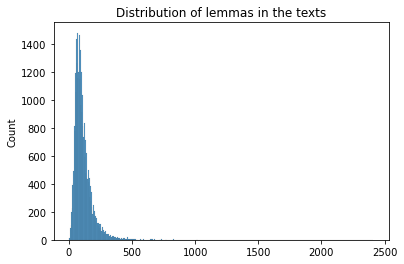

In [9]:
# Build the histogram, distribution of lemmas in the texts
sns.histplot(lengths).set_title("Distribution of lemmas in the texts")

In [19]:
# Defining dictionary and corpus with Gensim
dictionary = corpora.Dictionary(docs)
corpus = [dictionary.doc2bow(text) for text in docs]

In [22]:
def calculate_coherence(dictionary, corpus, docs, start, stop):
    scores = []
    for topics in range(start, stop):
        
        # defining the model
        lda_model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=26, alpha='auto', eval_every=5)

        # U_mass coherence score
        cm_u_mass = CoherenceModel(model=lda_model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        u_mass_coherence = cm_u_mass.get_coherence()
        
        # C_v coherence score
        cm_c_v = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
        c_v_coherence = cm_c_v.get_coherence()
        
        values = [topics, u_mass_coherence, c_v_coherence]
        
        scores.append(values)
        
    return scores

In [ ]:
scores = calculate_coherence(dictionary, corpus, docs, 10, 30)

In [24]:
scores

[[10, -2.0793481811540526, 0.4633946014323295],
 [11, -2.115491781869903, 0.4527058317814372],
 [12, -2.074979255120663, 0.4644513910791348],
 [13, -1.9818163130550128, 0.45256188687696464],
 [14, -2.061858534817608, 0.47441677974300467],
 [15, -2.030151902555837, 0.46666258449789794],
 [16, -1.9989640340170747, 0.46791435807817094],
 [17, -2.004065413399135, 0.4759551343456772],
 [18, -2.027104336962235, 0.4541813978485001],
 [19, -2.142492549584389, 0.4646652451137604],
 [20, -2.170916630851939, 0.47435172801934944],
 [21, -1.8563690057776416, 0.4820134146365182],
 [22, -2.0526168490098247, 0.4933616388897079],
 [23, -2.0100578763012207, 0.4612177221084147],
 [24, -2.0418909183606155, 0.4652635980129635],
 [25, -1.9746158990956137, 0.46592065910972646],
 [26, -2.092387784745026, 0.4781290734988557],
 [27, -2.1074529681884724, 0.47783221696560213],
 [28, -2.009590926476389, 0.4710348495757927],
 [29, -1.9726938043056454, 0.4898496113042988]]

In [26]:
df = pd.DataFrame(scores, columns = ['number_of_topics','u_mass_coherence','c_v_coherence'])

In [37]:
# tidying the dataframe
df = df.melt(id_vars=['number_of_topics'], value_vars=['u_mass_coherence','c_v_coherence'])

In [39]:
# save the data for future use
df.to_csv('model_scores.csv')

In [11]:
df = pd.read_csv('model_scores.csv')

Text(0.5, 1.0, 'u_mass coherence')

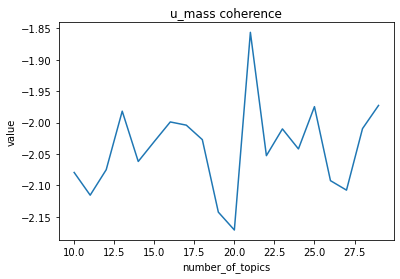

In [12]:
# Plotting u_mass_coherence
sns.lineplot(data=df.loc[df['variable'] == 'u_mass_coherence'], x="number_of_topics", y="value").set_title('u_mass coherence')

Text(0.5, 1.0, 'c_v coherence')

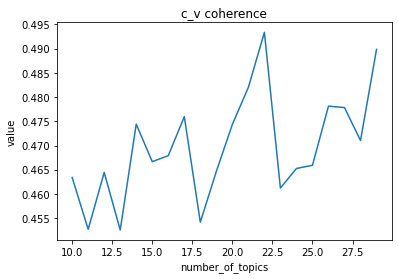

In [13]:
# Plotting c_v_coherence
sns.lineplot(data=df.loc[df['variable'] == 'c_v_coherence'], x="number_of_topics", y="value").set_title('c_v coherence')

In [20]:
lda_model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics=22, alpha='auto', eval_every=5)

In [24]:
# print topics
lda_model.print_topics(-1)

[(0,
  '0.034*"startup" + 0.034*"founder" + 0.024*"event" + 0.024*"company" + 0.014*"time" + 0.014*"investor" + 0.013*"entrepreneur" + 0.012*"people" + 0.012*"ticket" + 0.012*"team"'),
 (1,
  '0.035*"company" + 0.033*"space" + 0.032*"patent" + 0.018*"technology" + 0.013*"internet" + 0.012*"year" + 0.011*"network" + 0.010*"launch" + 0.008*"hardware" + 0.007*"time"'),
 (2,
  '0.028*"company" + 0.024*"security" + 0.014*"user" + 0.011*"service" + 0.010*"code" + 0.009*"device" + 0.009*"developer" + 0.009*"time" + 0.008*"system" + 0.008*"startup"'),
 (3,
  '0.034*"video" + 0.032*"game" + 0.029*"content" + 0.022*"ad" + 0.018*"user" + 0.017*"music" + 0.017*"platform" + 0.015*"company" + 0.013*"medium" + 0.012*"publisher"'),
 (4,
  '0.043*"startup" + 0.029*"company" + 0.025*"investment" + 0.024*"entrepreneur" + 0.021*"tech" + 0.017*"fund" + 0.016*"investor" + 0.016*"city" + 0.015*"year" + 0.014*"business"'),
 (5,
  '0.022*"company" + 0.021*"home" + 0.019*"startup" + 0.018*"site" + 0.016*"market

## 6. Vizualizing the results

In [25]:
pyLDAvis.enable_notebook()
viz = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
viz

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
9      0.020535  0.052913       1        1  13.218008
8     -0.051374  0.038722       2        1  10.205250
4     -0.012437 -0.123558       3        1   7.101074
0     -0.015231 -0.118283       4        1   6.958938
3     -0.029758  0.066241       5        1   6.812487
19    -0.126195 -0.072716       6        1   6.460587
6      0.054921  0.051131       7        1   5.507048
18    -0.122604  0.065233       8        1   4.633957
14     0.116463  0.098657       9        1   4.162672
17    -0.062047  0.110446      10        1   3.935584
12    -0.130330 -0.119361      11        1   3.750708
5     -0.098606  0.024338      12        1   3.622432
2      0.040907 -0.011749      13        1   3.518023
10    -0.064595  0.054291      14        1   3.000501
15    -0.082262  0.167654      15        1   2.713506
16     0.077902 -0.062107      16        1   2.599185
7      0.103871 -0.015189      17        1   2.391982
11     0.221439  0.054646      18        1   2.290026
13     0.080431 -0.139853      19        1   1.969590
21    -0.032777 -0.073356      20        1   1.876757
1      0.077255  0.008258      21        1   1.869800
20     0.034493 -0.056359      22        1   1.401885, topic_info=         Term          Freq         Total Category  logprob  loglift
11      datum  29931.000000  29931.000000  Default  30.0000  30.0000
60    startup  74949.000000  74949.000000  Default  29.0000  29.0000
58    service  47039.000000  47039.000000  Default  28.0000  28.0000
446      deal  22553.000000  22553.000000  Default  27.0000  27.0000
276       app  41912.000000  41912.000000  Default  26.0000  26.0000
..        ...           ...           ...      ...      ...      ...
298     thing    310.341638  17604.221274  Topic22  -5.2989   0.2291
316       day    305.876726  16879.655220  Topic22  -5.3134   0.2567
140      time    310.660451  39976.549786  Topic22  -5.2979  -0.5900
46     people    288.869288  31238.918503  Topic22  -5.3706  -0.4161
314  consumer    281.569909  14912.966870  Topic22  -5.3962   0.2977

[1747 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
2384      6  0.955262  1.2b
9604     20  0.967149  17th
4499      3  0.950808  1960
2117      1  0.100529  1990
2117      2  0.005913  1990
...     ...       ...   ...
70       20  0.019465  year
70       21  0.021618  year
70       22  0.010877  year
6252      1  0.009725   yen
6252      8  0.972505   yen

[11505 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 9, 5, 1, 4, 20, 7, 19, 15, 18, 13, 6, 3, 11, 16, 17, 8, 12, 14, 22, 2, 21])

## 7. Saving the model to the disk

In [28]:
temp_file = datapath('model')
lda_model.save(temp_file)